**XÂY DỰNG MÔ HÌNH ĐỂ PHÂN LOẠI TRÁI CÂY RAU BẰNG HÌNH ẢNH**

---



#Khai báo thư viện

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sn
import os
import shutil
import json
import cv2
import time
from collections import defaultdict
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Activation, Dropout, Lambda, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2, ResNet50, EfficientNetB0, DenseNet121, Xception, VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Chuẩn bị dữ liệu

##Tổng quan về dữ liệu


---



**Tên Dataset** : Fruits-360

Tác giả: Mihai Oltean

Phiên bản mới nhất: 2025.03.24.0

Thành phần: Hình ảnh của hơn 100 loại trái cây, rau củ, hạt và hạt giống khác nhau, bao gồm nhiều giống như táo (Crimson Snow, Golden, Granny Smith, Pink Lady, Red Delicious), chuối (vàng, đỏ, Lady Finger), nho (xanh, hồng, trắng), cà chua (nhiều loại), dưa hấu, dâu tây, cà rốt, bắp cải, hành tây, khoai tây, chanh, cam, ớt, v.v.

##Tải dữ liệu về

---



In [ ]:
#Tải dữ liệu từ thư mục data trong github
!wget https://github.com/20khanh03/PPNCKH/raw/refs/heads/main/data/Fruit-Images-Dataset-master.zip?download= -O fruits-360.zip
#Giải nén file dữ liệu
!unzip fruits-360.zip -d ./fruits-360/

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: ./fruits-360/Fruit-Images-Dataset-master/Training/Strawberry Wedge/242_100.jpg  
  inflating: ./fruits-360/Fruit-Images-Dataset-master/Training/Strawberry Wedge/243_100.jpg  
  inflating: ./fruits-360/Fruit-Images-Dataset-master/Training/Strawberry Wedge/244_100.jpg  
  inflating: ./fruits-360/Fruit-Images-Dataset-master/Training/Strawberry Wedge/245_100.jpg  
  inflating: ./fruits-360/Fruit-Images-Dataset-master/Training/Strawberry Wedge/246_100.jpg  
  inflating: ./fruits-360/Fruit-Images-Dataset-master/Training/Strawberry Wedge/247_100.jpg  
  inflating: ./fruits-360/Fruit-Images-Dataset-master/Training/Strawberry Wedge/248_100.jpg  
  inflating: ./fruits-360/Fruit-Images-Dataset-master/Training/Strawberry Wedge/249_100.jpg  
  inflating: ./fruits-360/Fruit-Images-Dataset-master/Training/Strawberry Wedge/24_100.jpg  
  inflating: ./fruits-360/Fruit-Images-Dataset-master/Training/Strawberry Wedge/250_100.jpg  
  in

##Chia dữ liệu

---



In [ ]:
unzipped_data_root = './fruits-360/Fruit-Images-Dataset-master'

original_train_dir = os.path.join(unzipped_data_root, 'Training')
original_test_dir = os.path.join(unzipped_data_root, 'Test')

print(f"Original Training Dir: {original_train_dir}, Exists: {os.path.exists(original_train_dir)}")
print(f"Original Test Dir: {original_test_dir}, Exists: {os.path.exists(original_test_dir)}")

Original Training Dir: ./fruits-360/Fruit-Images-Dataset-master/Training, Exists: True
Original Test Dir: ./fruits-360/Fruit-Images-Dataset-master/Test, Exists: True


In [ ]:
# Danh sách 131 nhãn gốc
original_labels = ['Apple Braeburn', 'Apple Crimson Snow', 'Apple Pink Lady', 'Apple Red 2', 'Apple Red Yellow 1', 'Apricot'
                  'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Beetroot', 'Blueberry'
                  'Cactus fruit', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2'
                  'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Chestnut', 'Clementine', 'Cocos'
                  'Corn', 'Cucumber Ripe 2', 'Dates', 'Eggplant', 'Fig', 'Ginger Root'
                  'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3'
                  'Grape White 4', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki'
                  'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon', 'Lemon Meyer', 'Limes'
                  'Lychee', 'Mandarine', 'Mango', 'Mangostan', 'Maracuja', 'Melon Piel de Sapo'
                  'Mulberry', 'Nut Forest', 'Nut Pecan', 'Onion Red', 'Onion Red Peeled', 'Onion White'
                  'Orange', 'Papaya', 'Passion Fruit', 'Peach Flat', 'Pear 2', 'Pear Red'
                  'Pear Williams', 'Pepino', 'Pepper Green', 'Pepper Orange', 'Pepper Red', 'Pepper Yellow'
                  'Physalis', 'Physalis with Husk', 'Pineapple', 'Pineapple Mini', 'Pitahaya Red', 'Plum 2'
                  'Plum 3', 'Pomegranate', 'Pomelo Sweetie', 'Potato Red Washed', 'Potato Sweet', 'Potato White'
                  'Quince', 'Rambutan', 'Raspberry', 'Redcurrant', 'Salak', 'Strawberry'
                  'Strawberry Wedge', 'Tamarillo', 'Tangelo', 'Tomato 1', 'Tomato 4', 'Tomato Cherry Red'
                  'Tomato Yellow', 'Walnut', 'Watermelon']

grouping_rules = {
    'Apple': 'Apple',
    'Banana': 'Banana',
    'Avocado': 'Avocado',
    'Apricot': 'Apricot',
    'Cherry': 'Cherry',
    'Pear': 'Pear',
    'Peach': 'Peach',
    'Plum': 'Plum',
    'Grape': 'Grape',
    'Tomato Yellow': 'Tomato Yellow',
    'Tomato': 'Tomato',
    'Pepper Green':'Pepper Green',
    'Pepper Orange':'Pepper Orange',
    'Pepper Red':'Pepper Red',
    'Pepper Yellow':'Pepper Yellow',
    'Potato': 'Potato',
    'Onion Red': 'Onion Red',
    'Onion Red Peeled': 'Onion Red Peeled',
    'Onion White' : 'Onion White',
    'Chestnut': 'Nut',
    'Cucumber': 'Cucumber',
    'Melon': 'Melon',
    'Mango': 'Mango',
    'Strawberry': 'Strawberry',
    'Pineapple': 'Pineapple',
    'Physalis': 'Physalis',
    'Orange': 'Orange',
    'Grapefruit': 'Grapefruit',
    'Mandarine': 'Mandarine',
    'Lemon': 'Lemon',
    'Lime': 'Lime',
    'Kiwi': 'Kiwi',
    'Watermelon': 'Watermelon',
}

grouped_labels = defaultdict(list)
for label in original_labels:
    matched = False
    for keyword, group in grouping_rules.items():
        if keyword in label:
            grouped_labels[group].append(label)
            matched = True
            break
    if not matched:
        grouped_labels[label].append(label)

grouped_labels = dict(grouped_labels)

labels = sorted(grouped_labels.keys())
group_names = labels

num_classes = len(labels)
print(f"Tổng số nhãn: {num_classes}")
print("Tên các nhãn nhóm:")
for i in range(0, len(labels), 10):
    print("   " + ", ".join(f"'{l}'" for l in labels[i:i+10]))


Tổng số nhãn: 60
Tên các nhãn nhóm:
   'Apple', 'Avocado', 'Banana', 'Beetroot', 'BlueberryCactus fruit', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry', 'Clementine'
   'CocosCorn', 'Cucumber', 'Dates', 'Eggplant', 'Fig', 'Ginger RootGranadilla', 'Grape', 'Guava', 'Hazelnut', 'Huckleberry'
   'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon', 'Lime', 'Mandarine', 'Mango', 'Maracuja', 'Melon', 'Nut'
   'Nut Forest', 'Nut Pecan', 'Onion Red', 'Onion White', 'Papaya', 'Passion Fruit', 'Peach', 'Pear', 'Pepino', 'Pepper Green'
   'Pepper Orange', 'Pepper Red', 'Pepper Yellow', 'Physalis', 'Pineapple', 'Pitahaya Red', 'Plum', 'Pomegranate', 'Pomelo Sweetie', 'Potato'
   'Rambutan', 'Raspberry', 'Redcurrant', 'Salak', 'Strawberry', 'Tamarillo', 'Tangelo', 'Tomato', 'Walnut', 'Watermelon'


In [ ]:
for idx, label in enumerate(group_names):
    print(f"{idx:2d}: {label}")

 0: Apple
 1: Avocado
 2: Banana
 3: Beetroot
 4: BlueberryCactus fruit
 5: Cantaloupe 2
 6: Carambula
 7: Cauliflower
 8: Cherry
 9: Clementine
10: CocosCorn
11: Cucumber
12: Dates
13: Eggplant
14: Fig
15: Ginger RootGranadilla
16: Grape
17: Guava
18: Hazelnut
19: Huckleberry
20: Kiwi
21: Kohlrabi
22: Kumquats
23: Lemon
24: Lime
25: Mandarine
26: Mango
27: Maracuja
28: Melon
29: Nut
30: Nut Forest
31: Nut Pecan
32: Onion Red
33: Onion White
34: Papaya
35: Passion Fruit
36: Peach
37: Pear
38: Pepino
39: Pepper Green
40: Pepper Orange
41: Pepper Red
42: Pepper Yellow
43: Physalis
44: Pineapple
45: Pitahaya Red
46: Plum
47: Pomegranate
48: Pomelo Sweetie
49: Potato
50: Rambutan
51: Raspberry
52: Redcurrant
53: Salak
54: Strawberry
55: Tamarillo
56: Tangelo
57: Tomato
58: Walnut
59: Watermelon


In [ ]:
train_dir = 'Training_Grouped'  # nơi sẽ chứa các thư mục đã gộp

# Tạo thư mục đích nếu chưa có
os.makedirs(train_dir, exist_ok=True)

# Dùng lại grouped_labels từ trước
for group, original_classes in grouped_labels.items():
    group_path = os.path.join(train_dir, group)
    os.makedirs(group_path, exist_ok=True)

    for original_class in original_classes:
        original_class_path = os.path.join(original_train_dir, original_class)
        if not os.path.exists(original_class_path):
            continue
        for filename in os.listdir(original_class_path):
            src = os.path.join(original_class_path, filename)
            dst = os.path.join(group_path, filename)
            if os.path.isfile(src):
                shutil.copy2(src, dst)

# Liệt kê vài nhóm thư mục đầu tiên để xác nhận
os.listdir(train_dir)[:10]


['Nut Pecan',
 'Pineapple',
 'Watermelon',
 'Strawberry',
 'Salak',
 'Clementine',
 'Plum',
 'Hazelnut',
 'Tomato',
 'Cherry']

In [ ]:
test_dir = 'Test_Grouped'  # nơi sẽ chứa các thư mục đã gộp

# Tạo thư mục đích nếu chưa có
os.makedirs(test_dir, exist_ok=True)

# Dùng lại grouped_labels từ trước
for group, original_classes in grouped_labels.items():
    group_path = os.path.join(test_dir, group)
    os.makedirs(group_path, exist_ok=True)

    for original_class in original_classes:
        original_class_path = os.path.join(original_test_dir, original_class)
        if not os.path.exists(original_class_path):
            continue
        for filename in os.listdir(original_class_path):
            src = os.path.join(original_class_path, filename)
            dst = os.path.join(group_path, filename)
            if os.path.isfile(src):
                shutil.copy2(src, dst)

# Liệt kê vài nhóm thư mục đầu tiên để xác nhận
os.listdir(test_dir)[:10]


['Nut Pecan',
 'Pineapple',
 'Watermelon',
 'Strawberry',
 'Salak',
 'Clementine',
 'Plum',
 'Hazelnut',
 'Tomato',
 'Cherry']

#Phân tích và khai phá dữ liệu / EDA

In [ ]:
data = []

for label in os.listdir(train_dir):
    label_path = os.path.join(train_dir, label)
    if os.path.isdir(label_path):
        for fname in os.listdir(label_path):
            fpath = os.path.join(label_path, fname)
            try:
                with Image.open(fpath) as img:
                    width, height = img.size
                    mode = img.mode
                    data.append({
                        "filename": fname,
                        "label": label,
                        "width": width,
                        "height": height,
                        "mode": mode,
                    })
            except Exception as e:
                data.append({
                    "filename": fname,
                    "label": label,
                    "width": None,
                    "height": None,
                    "mode": "ERROR",
                })

df = pd.DataFrame(data)

In [ ]:
#Xem thông tin của 10 ảnh ngẫu nhiên
df.sample(10)

,filename,label,width,height,mode
14530,r_158_100.jpg,Carambula,100,100,RGB
26736,r2_74_100.jpg,Walnut,100,100,RGB
13949,136_100.jpg,Fig,100,100,RGB
4051,r_106_100.jpg,Cherry,100,100,RGB
13310,r2_187_100.jpg,Cauliflower,100,100,RGB
25348,265_100.jpg,Banana,100,100,RGB
17448,r_278_100.jpg,Pepper Red,100,100,RGB
14726,r_18_100.jpg,Papaya,100,100,RGB
2863,251_100.jpg,Hazelnut,100,100,RGB
7844,r2_262_100.jpg,Pear,100,100,RGB


##Kiểm tra dữ liệu

In [ ]:
#Tổng quan dữ liệu
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27655 entries, 0 to 27654
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  27655 non-null  object
 1   label     27655 non-null  object
 2   width     27655 non-null  int64 
 3   height    27655 non-null  int64 
 4   mode      27655 non-null  object
dtypes: int64(2), object(3)
memory usage: 1.1+ MB
None


* Tổng cộng có 27655 ảnh trong tệp Training
* Không có dữ liệu bị thiếu
* Kích thước ảnh (width x height) ở dạng số nguyên (int64)

In [ ]:
df.describe()

,width,height
count,27655.0,27655.0
mean,100.0,100.0
std,0.0,0.0
min,100.0,100.0
25%,100.0,100.0
50%,100.0,100.0
75%,100.0,100.0
max,100.0,100.0


* Tất cả ảnh đều có kích thước đúng bằng 100×100 pixels

* Không có độ lệch chuẩn (std = 0), nên mọi ảnh đều có cùng kích thước

In [ ]:
#Kiểm tra ảnh lỗi, thiếu thông
df.isnull().sum()

,0
filename,0
label,0
width,0
height,0
mode,0


In [ ]:
#Kiểm tra ảnh trùng
df [df.duplicated()]

,filename,label,width,height,mode


In [ ]:
df['mode'].value_counts()


,count
mode,
RGB,27655


##Phân bố đặc trưng

In [ ]:
print("Số lượng ảnh mỗi nhãn:")
print(df['label'].value_counts())

Số lượng ảnh mỗi nhãn:
label
Grape             1146
Tomato             851
Walnut             735
Banana             723
Pepper Orange      702
Fig                702
Cauliflower        702
Pear               696
Pepper Red         666
Nut Forest         654
Cherry             651
Apple              629
Pineapple          621
Lemon              577
Onion Red          565
Potato             557
Nut Pecan          534
Mango              519
Redcurrant         492
Peach              492
Pomegranate        492
Cantaloupe 2       492
Papaya             492
Physalis           492
Rambutan           492
Avocado            491
Salak              490
Tamarillo          490
Huckleberry        490
Pepino             490
Clementine         490
Dates              490
Passion Fruit      490
Pitahaya Red       490
Tangelo            490
Mandarine          490
Carambula          490
Raspberry          490
Maracuja           490
Kumquats           490
Guava              490
Watermelon         475
Kohlr

<ipython-input-19-6c063a62b3e4>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sn.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


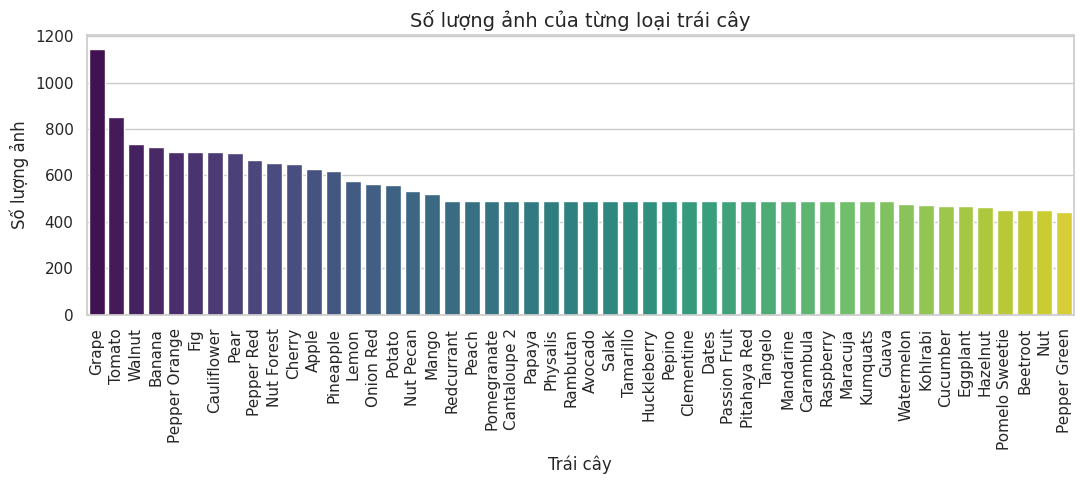

In [ ]:
sn.set(style="whitegrid")

# Đếm số lượng ảnh mỗi class
class_counts = df['label'].value_counts()

# Vẽ biểu đồ
plt.figure(figsize=(11, 5))
sn.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")

plt.title("Số lượng ảnh của từng loại trái cây", fontsize=14)
plt.xlabel("Trái cây")
plt.ylabel("Số lượng ảnh")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Class nhiều nhất (Grape: 1146 ảnh) gấp hơn 2.5 lần so với class ít nhất (Pepper Green: 444 ảnh).

Nhãn từ 490 trở xuống khá đều, nhưng có một số class cao vượt trội (Grape, Tomato, Walnut,...).

→ Dữ liệu mất cân bằng nhẹ đến vừa.



Dữ liệu bị mất cân bằng nhẹ tuy mức chênh lệch không quá nghiêm trọng nhưng có thể khiến mô hình thiên lệch học tốt các lớp phổ biến và bỏ qua các lớp ít hơn, dẫn đến độ chính xác tổng thể cao nhưng kém ở những lớp ít dữ liệu.

**Cách giải quyết đề xuất:**
Thay vì làm tăng hoặc giảm số lượng mẫu, ta sẽ sử dụng **class_weight** trong quá trình huấn luyện. Kỹ thuật này giúp mô hình ưu tiên học nhiều hơn từ các lớp có ít dữ liệu, bằng cách tăng độ quan trọng (trọng số) cho các lớp đó trong hàm mất mát. Đây là giải pháp đơn giản, hiệu quả, và không làm thay đổi dữ liệu gốc.

#Tiền xử lý dữ liệu

##Chuẩn hóa dữ liệu

Đây là bước chuyển ảnh RGB → HSV + Grayscale, sau đó nối 2 kênh thành ảnh 4 kênh (HSV+Gray). Đây là một kỹ thuật giúp mô hình khai thác đặc trưng màu và độ sáng rõ ràng hơn.

In [ ]:
## Tạo một lớp tùy chỉnh chuyển đổi hình ảnh gốc từ
# RGB sang HSV và thang độ xám và nối các kết quả
# hình thành trong đầu vào có kích thước 100 x 100 x 4
from tensorflow.keras.models import load_model

def convert_to_hsv_and_grayscale(x):
    import tensorflow as tf
    hsv = tf.image.rgb_to_hsv(x)
    gray = tf.image.rgb_to_grayscale(x)
    rez = tf.concat([hsv, gray], axis=-1)
    return rez

##Tăng cường dữ liệu

In [ ]:
# Thay đổi ngẫu nhiên sắc độ và độ bão hòa của hình ảnh để mô phỏng các điều kiện ánh sáng thay đổi
def augment_image(x):
    import tensorflow as tf
    x = tf.image.random_saturation(x, 0.9, 1.2)
    x = tf.image.random_hue(x, 0.02)
    return x

In [ ]:
 def build_data_generators(train_folder, test_folder, validation_percent, labels=None, image_size=(100, 100), batch_size=50):
    train_datagen = ImageDataGenerator(
        width_shift_range=0.0,
        height_shift_range=0.0,
        zoom_range=0.0,
        horizontal_flip=True,
        vertical_flip=True,
        preprocessing_function=augment_image,
        validation_split=validation_percent)

    test_datagen = ImageDataGenerator()

    train_gen = train_datagen.flow_from_directory(train_folder, target_size=image_size, class_mode='sparse',
                                                  batch_size=batch_size, shuffle=True, subset='training', classes=labels)
    validation_gen = train_datagen.flow_from_directory(train_folder, target_size=image_size, class_mode='sparse',
                                                       batch_size=batch_size, shuffle=False, subset='validation', classes=labels)
    test_gen = test_datagen.flow_from_directory(test_folder, target_size=image_size, class_mode='sparse',
                                                batch_size=batch_size, shuffle=False, subset=None, classes=labels)

    return train_gen, validation_gen, test_gen

#Huấn luyện mô hình

Thuật toán:

Mô hình là một Convolutional Neural Network tuần tự gồm:

* 4 block (Conv2D → ReLU → MaxPooling2D) với số filter lần lượt 16, 32, 64, 128 (kernel 5×5).

* Tiếp theo là Flatten(), hai Dense (1024, 256) kèm Dropout(0.2), cuối cùng Dense(num_classes, softmax).

* Optimizer dùng Adadelta với learning rate động.

##Xây dựng mô hình

Cài đặt các tham số mô hình

In [10]:
#Tham số cấu hình
learning_rate = 0.1
min_learning_rate = 0.00001
learning_rate_reduction_factor = 0.5
patience = 3
verbose = 1
image_size = (100, 100)
input_shape = (100, 100, 3)

In [ ]:
#Hàm xây dựng mô hình
def CNN(input_shape, num_classes):
    img_input = Input(shape=input_shape, name='data')
    x = Lambda(convert_to_hsv_and_grayscale)(img_input)
    x = Conv2D(16, (5, 5), strides=(1, 1), padding='same', name='conv1')(x)
    x = Activation('relu', name='conv1_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool1')(x)
    x = Conv2D(32, (5, 5), strides=(1, 1), padding='same', name='conv2')(x)
    x = Activation('relu', name='conv2_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool2')(x)
    x = Conv2D(64, (5, 5), strides=(1, 1), padding='same', name='conv3')(x)
    x = Activation('relu', name='conv3_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool3')(x)
    x = Conv2D(128, (5, 5), strides=(1, 1), padding='same', name='conv4')(x)
    x = Activation('relu', name='conv4_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool4')(x)
    x = Flatten()(x)
    x = Dense(1024, activation='relu', name='fcl1')(x)
    x = Dropout(0.2)(x)
    x = Dense(256, activation='relu', name='fcl2')(x)
    x = Dropout(0.2)(x)
    out = Dense(num_classes, activation='softmax', name='predictions')(x)
    rez = Model(inputs=img_input, outputs=out)
    return rez

##Trainning

In [11]:
#Tạo file lưu trữ mô hình sau khi huấn luyện
output_dir = "/content/drive/MyDrive/models"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#Hàm huấn luyện và cải tiến mô hình
def train_and_evaluate_model(model, name="", epochs=25, batch_size=50, verbose=verbose, useCkpt=False):
    print(model.summary())
    model_out_dir = os.path.join(output_dir, name)
    if not os.path.exists(model_out_dir):
        os.makedirs(model_out_dir)

    print(f"Training folder: {train_dir}")
    print(f"Testing folder: {test_dir}")
    print(f"Available classes: {os.listdir(train_dir)}")

    trainGen, validationGen, testGen = build_data_generators(train_dir, test_dir, validation_percent=0.1, labels=group_names, image_size=image_size, batch_size=batch_size)
    y_train = trainGen.classes  # các nhãn đã được ánh xạ thành số
    class_weights_array = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weights = dict(enumerate(class_weights_array))

    if trainGen.n == 0:
        raise ValueError(f"No training images found in {train_dir}. Please check the path and the contents of the folder.")
    if validationGen.n == 0:
        raise ValueError(f"No validation images found in {train_dir}. Please check the path and the contents of the folder.")
    if testGen.n == 0:
        raise ValueError(f"No testing images found in {test_dir}. Please check the path and the contents of the folder.")

    optimizer = Adadelta(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=patience, verbose=verbose,
                                                factor=learning_rate_reduction_factor, min_lr=min_learning_rate)
    save_model = ModelCheckpoint(filepath=model_out_dir + "/model.h5", monitor='val_accuracy', verbose=verbose,
                             save_best_only=True, save_weights_only=False, mode='max', save_freq=1)
    start_time = time.time()
    history = model.fit(trainGen,
                                  epochs=epochs,
                                  steps_per_epoch=(trainGen.n // batch_size) + 1,
                                  validation_data=validationGen,
                                  validation_steps=(validationGen.n // batch_size) + 1,
                                  verbose=verbose,
                                  callbacks=[learning_rate_reduction, save_model],
                                  class_weight=class_weights,)
    elapsed_time = time.time() - start_time
    with open(model_out_dir + "/history.json", "w") as f:
      json.dump(history.history, f)

    model.save(model_out_dir + "/model.keras")

    #model.load_weights(model_out_dir + "/model.h5")

    validationGen.reset()
    loss_v, accuracy_v = model.evaluate(validationGen, steps=(validationGen.n // batch_size) + 1, verbose=verbose)
    loss, accuracy = model.evaluate(testGen, steps=(testGen.n // batch_size) + 1, verbose=verbose)
    print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
    print("Test: accuracy = %f  ;  loss_v = %f" % (accuracy, loss))

    summary_file = os.path.join(output_dir, "summary_results.csv")
    result = {
        "model_name": name,
        "val_accuracy": accuracy_v,
        "val_loss": loss_v,
        "test_accuracy": accuracy,
        "test_loss": loss,
        "epochs": len(history.history["loss"]),
        "time_sec": round(elapsed_time, 2),
    }

    if os.path.exists(summary_file):
        df = pd.read_csv(summary_file)
        df = pd.concat([df, pd.DataFrame([result])], ignore_index=True)
    else:
        df = pd.DataFrame([result])

    df.to_csv(summary_file, index=False)

    return history, model_out_dir, testGen, batch_size


In [ ]:
model_cnn = CNN(input_shape=input_shape, num_classes=num_classes)
train_and_evaluate_model(model_cnn, name="CNN_model", useCkpt=False)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data (InputLayer)               │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 100, 100, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 100, 100, 16)   │         1,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (Activation)         │ (None, 100, 100, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 50, 50, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 50, 50, 32)     │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_relu (Activation)         │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 25, 25, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_relu (Activation)         │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 12, 12, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4_relu (Activation)         │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool4 (MaxPooling2D)            │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fcl1 (Dense)                    │ (None, 1024)           │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fcl2 (Dense)                    │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 60)             │        15,420 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,268,076 (20.10 MB)

 Trainable params: 5,268,076 (20.10 MB)

 Non-trainable params: 0 (0.00 B)

None
Training folder: Training_Grouped
Testing folder: Test_Grouped
Available classes: ['Mango', 'Banana', 'Tamarillo', 'Papaya', 'CocosCorn', 'Plum', 'Pitahaya Red', 'Tomato', 'Watermelon', 'Salak', 'Nut Forest', 'Pepper Yellow', 'Redcurrant', 'Strawberry', 'Carambula', 'Nut Pecan', 'Passion Fruit', 'Physalis', 'Huckleberry', 'Fig', 'Apple', 'Rambutan', 'Peach', 'Cucumber', 'Cherry', 'Avocado', 'Cauliflower', 'Pineapple', 'Kumquats', 'Onion Red', 'Dates', 'Beetroot', 'Melon', 'Pepper Green', 'Cantaloupe 2', 'BlueberryCactus fruit', 'Guava', 'Pepino', 'Maracuja', 'Pepper Orange', 'Onion White', 'Pomelo Sweetie', 'Potato', 'Hazelnut', 'Nut', 'Mandarine', 'Raspberry', 'Walnut', 'Clementine', 'Grape', 'Kiwi', 'Lemon', 'Kohlrabi', 'Pomegranate', 'Eggplant', 'Ginger RootGranadilla', 'Lime', 'Tangelo', 'Pepper Red', 'Pear']
Found 24902 images belonging to 60 classes.
Found 2753 images belonging to 60 classes.
Found 10178 images belonging to 60 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
  3/499 ━━━━━━━━━━━━━━━━━━━━ 46s 93ms/step - accuracy: 0.0100 - loss: 4.2221    

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:202: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=self._current_epoch, batch=batch, logs=logs)


499/499 ━━━━━━━━━━━━━━━━━━━━ 121s 228ms/step - accuracy: 0.1856 - loss: 3.0956 - val_accuracy: 0.6695 - val_loss: 1.0624 - learning_rate: 0.1000
Epoch 2/25
499/499 ━━━━━━━━━━━━━━━━━━━━ 107s 215ms/step - accuracy: 0.7579 - loss: 0.7695 - val_accuracy: 0.9208 - val_loss: 0.2387 - learning_rate: 0.1000
Epoch 3/25
499/499 ━━━━━━━━━━━━━━━━━━━━ 98s 197ms/step - accuracy: 0.8996 - loss: 0.3083 - val_accuracy: 0.9386 - val_loss: 0.1939 - learning_rate: 0.1000
Epoch 4/25
499/499 ━━━━━━━━━━━━━━━━━━━━ 137s 188ms/step - accuracy: 0.9419 - loss: 0.1838 - val_accuracy: 0.9691 - val_loss: 0.0889 - learning_rate: 0.1000
Epoch 5/25
499/499 ━━━━━━━━━━━━━━━━━━━━ 93s 187ms/step - accuracy: 0.9600 - loss: 0.1269 - val_accuracy: 0.9517 - val_loss: 0.1415 - learning_rate: 0.1000
Epoch 6/25
499/499 ━━━━━━━━━━━━━━━━━━━━ 143s 189ms/step - accuracy: 0.9738 - loss: 0.0828 - val_accuracy: 0.9582 - val_loss: 0.1211 - learning_rate: 0.1000
Epoch 7/25
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9760 - lo

(<keras.src.callbacks.history.History at 0x7975be5d9d90>,
 '/content/drive/MyDrive/models/CNN_model fruit-360',
 50)

In [ ]:
model_cnn.save('/content/drive/MyDrive/models/CNN_Fruits360.h5')

#Đánh giá mô hình

In [ ]:
# tạo 2 biểu đồ, một biểu đồ về độ chính xác, một biểu đồ về tổn thất, để hiển thị sự tiến triển của hai số liệu này trong quá trình đào tạo
def plot_model_history(model_history, out_path=""):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    # summarize history for accuracy
    axs[0].plot(range(1, len(model_history.history['accuracy']) + 1), model_history.history['accuracy'])
    axs[0].plot(range(1, len(model_history.history['val_accuracy']) + 1), model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    #The following line was modified:
    axs[0].set_xticks(np.arange(1, len(model_history.history['accuracy']) + 1))
    # summarize history for loss
    axs[1].plot(range(1, len(model_history.history['loss']) + 1), model_history.history['loss'])
    axs[1].plot(range(1, len(model_history.history['val_loss']) + 1), model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    #The following line was modified as well:
    axs[1].set_xticks(np.arange(1, len(model_history.history['loss']) + 1))
    axs[1].legend(['train', 'val'], loc='best')
     if out_path:
        plt.savefig(out_path + "/acc_loss.png")
    plt.show()


In [ ]:
# tạo ma trận nhầm lẫn để biểu diễn trực quan các hình ảnh được phân loại không chính xác
def plot_confusion_matrix(y_true, y_pred, classes, out_path=""):
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index=[i for i in classes], columns=[i for i in classes])
    plt.figure(figsize=(40, 40))
    ax = sn.heatmap(df_cm, annot=True, square=True, fmt="d", linewidths=.2, cbar_kws={"shrink": 0.8})
    if out_path:
        plt.savefig(out_path + "/confusion_matrix.png")
    return ax

Found 24902 images belonging to 60 classes.
Found 2753 images belonging to 60 classes.
Found 10178 images belonging to 60 classes.
Test generator built successfully.


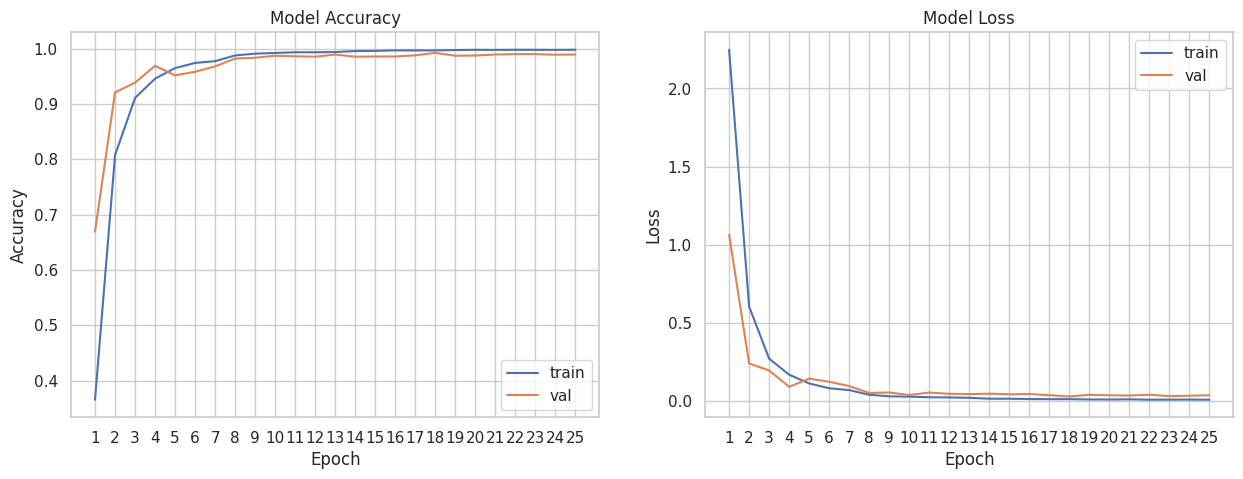

Accuracy/Loss plot generated.
Generating confusion matrix...
Predicting on 10178 test images in 204 steps.
204/204 ━━━━━━━━━━━━━━━━━━━━ 87s 423ms/step
Confusion matrix saved to /content/drive/MyDrive/models/CNN_model/confusion_matrix.png


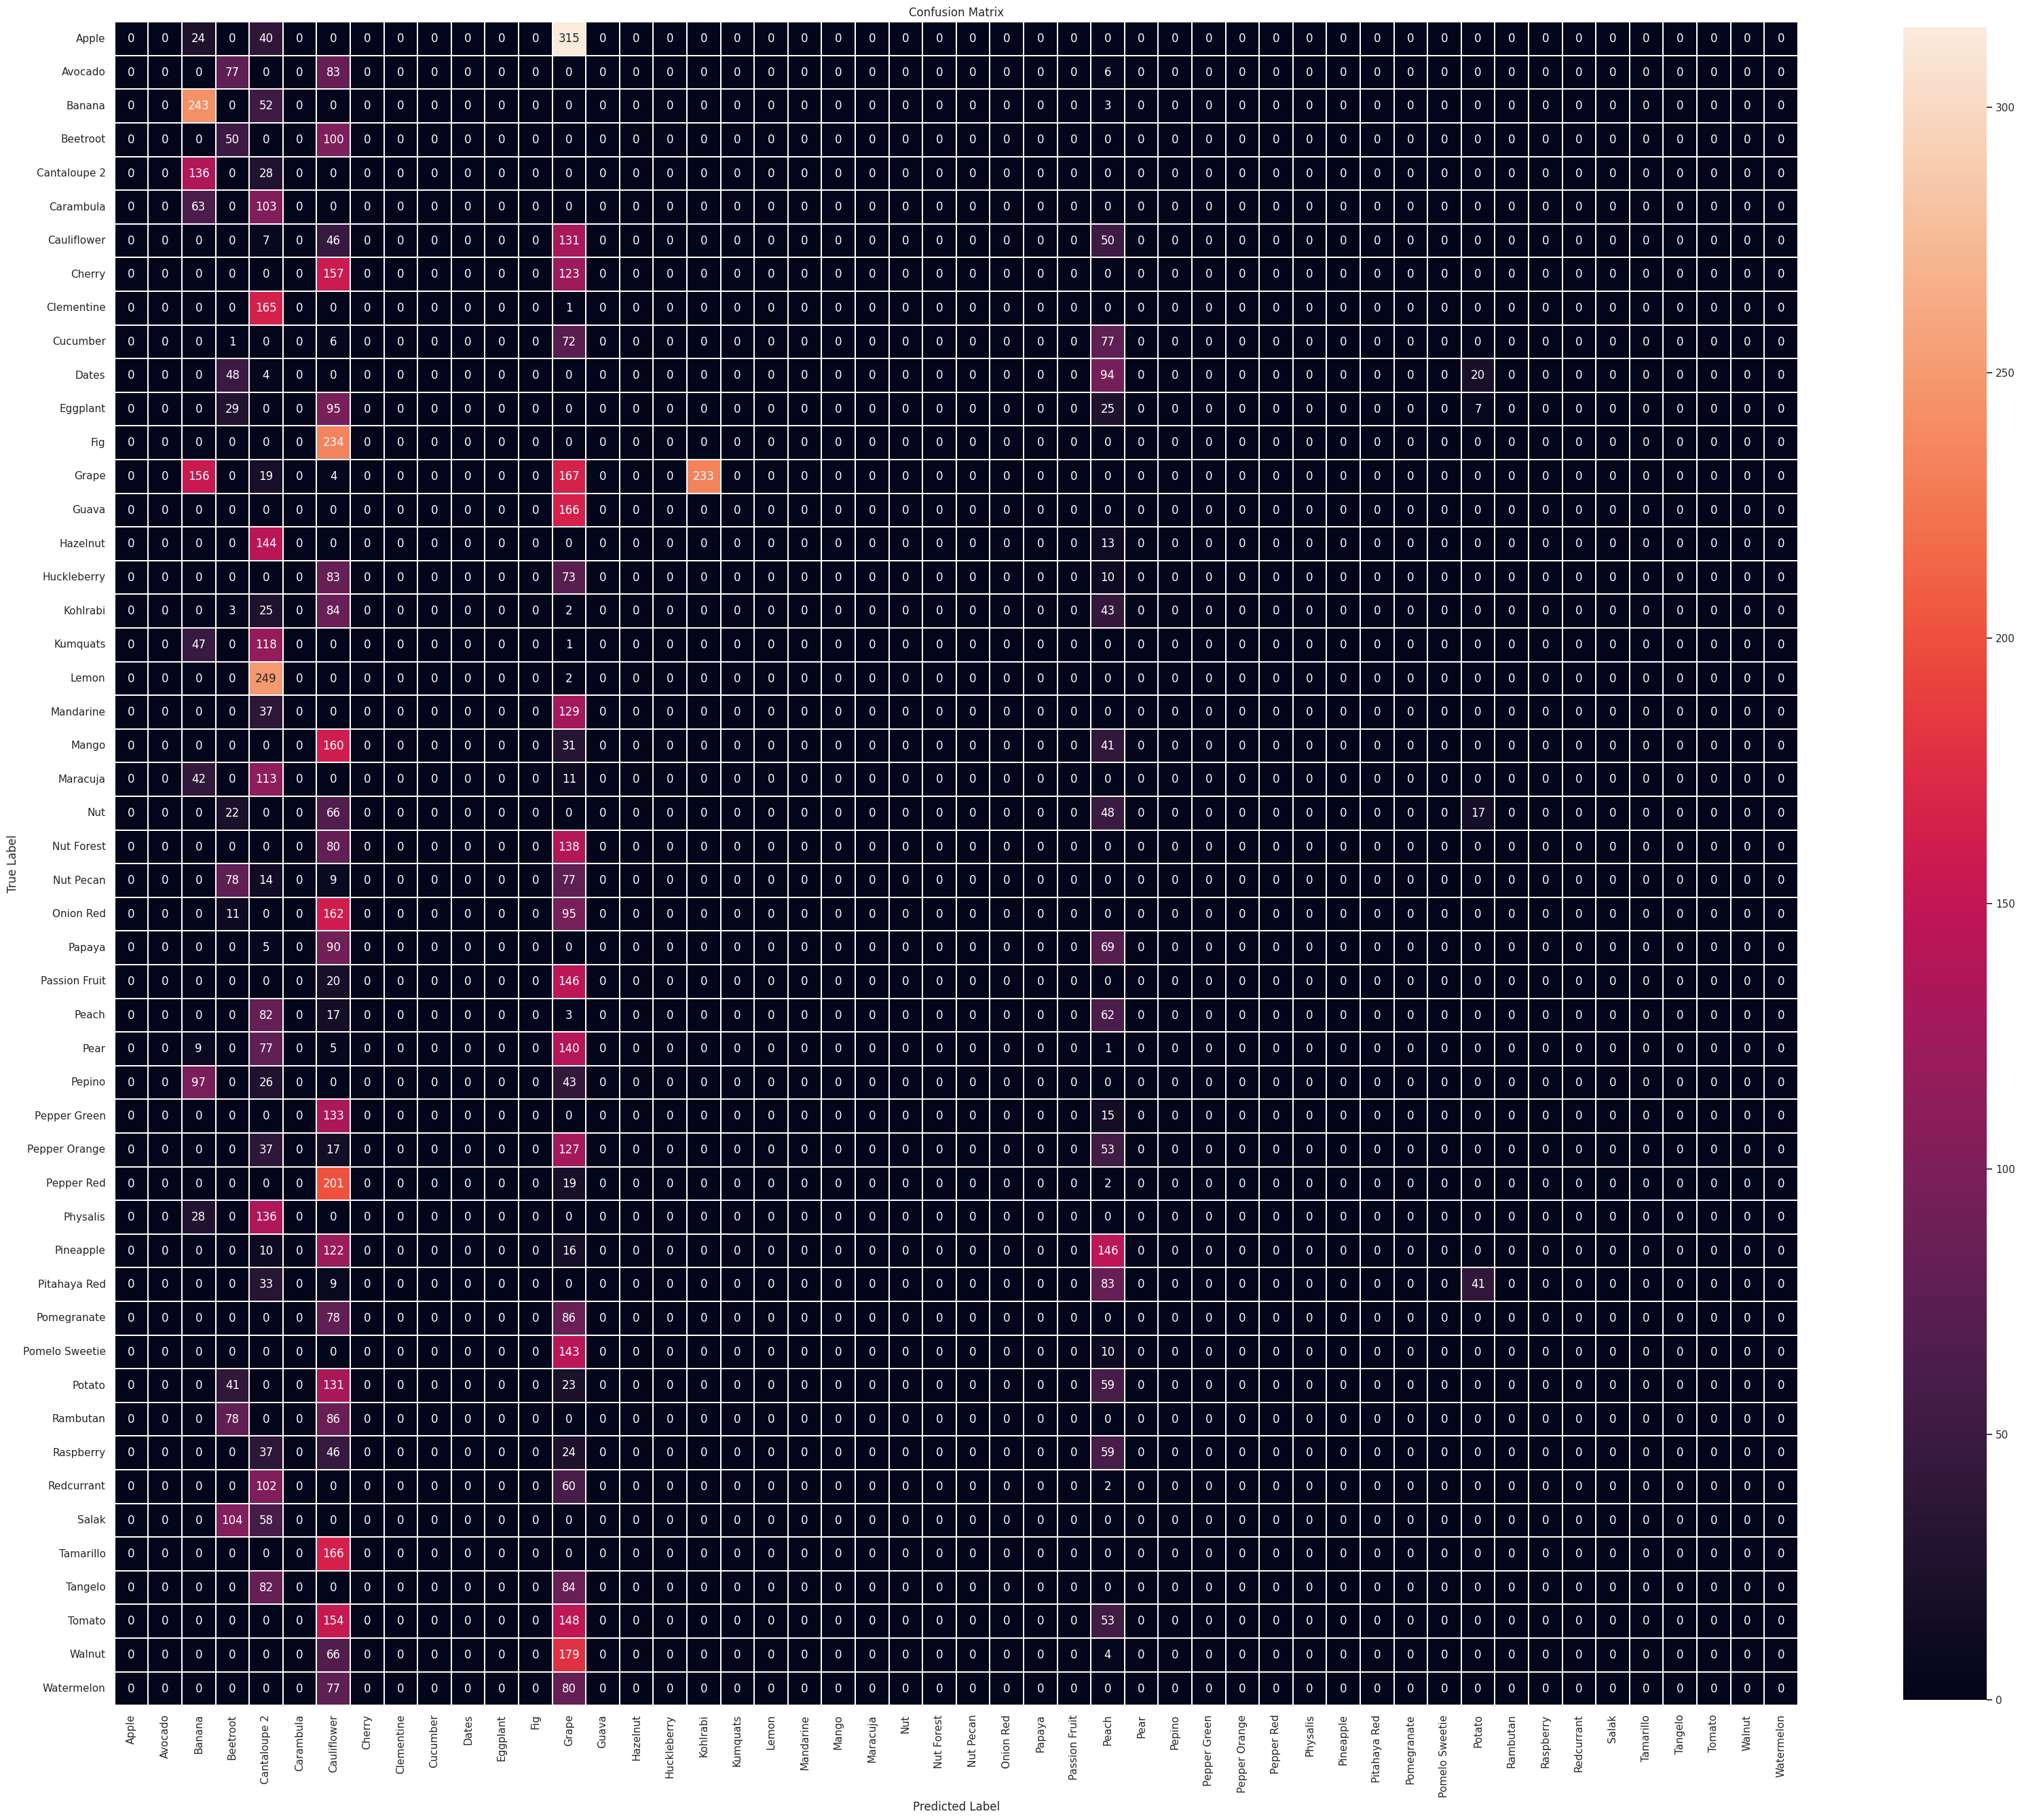

In [ ]:
from tensorflow.keras.models import load_model
import tensorflow as tf
import json
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
# Load mô hình với custom_objects
model_out_dir = "/content/drive/MyDrive/models/CNN_model"
model_path = os.path.join(model_out_dir, "model.keras")

if not os.path.exists(model_path):
    print(f"❌ Error: Model file not found at {model_path}")
else:
    model = tf.keras.models.load_model(
        model_path,
        custom_objects={"convert_to_hsv_and_grayscale": convert_to_hsv_and_grayscale},
        compile=False # Assuming the model is compiled during training
    )


    try:
        _, _, testGen = build_data_generators(
            train_folder=train_dir,
            test_folder=test_dir,
            validation_percent=0.1,
            labels=group_names,
            image_size=image_size,
            batch_size=50
        )
        print("Test generator built successfully.")
    except Exception as e:
        print(f"❌ Error building test generator: {e}")
        testGen = None

    if testGen and testGen.n > 0:
        # Load history để vẽ biểu đồ accuracy/loss
        history_file = os.path.join(model_out_dir, "history.json")
        if os.path.exists(history_file):
            with open(history_file, "r") as f:
                history_dict = json.load(f)

            class H:
                def __init__(self, h):
                    self.history = h
            history = H(history_dict)

            # Vẽ biểu đồ loss & accuracy
            plot_model_history(history, out_path=model_out_dir)
            print("Accuracy/Loss plot generated.")
        else:
             print(f"❌ Warning: history.json not found at {history_file}. Cannot plot history.")


        # Vẽ confusion matrix
        print("Generating confusion matrix...")
        testGen.reset()
        # Calculate steps for prediction
        steps = (testGen.n // testGen.batch_size) + 1
        print(f"Predicting on {testGen.n} test images in {steps} steps.")
        y_pred_probs = model.predict(testGen, steps=steps, verbose=1)
        y_pred = np.argmax(y_pred_probs, axis=-1)


        y_true = testGen.classes[testGen.index_array]

        unique_true_classes = np.unique(y_true)

         actual_classes_labels = [group_names[i] for i in unique_true_classes]

         cm = confusion_matrix(y_true, y_pred, labels=unique_true_classes)


         df_cm = pd.DataFrame(cm, index=actual_classes_labels, columns=actual_classes_labels)

         plt.figure(figsize=(40, 40))
        ax = sn.heatmap(df_cm, annot=True, square=True, fmt="d", linewidths=.2, cbar_kws={"shrink": 0.8})
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")

        if model_out_dir:
            cm_path = os.path.join(model_out_dir, "confusion_matrix.png")
            plt.savefig(cm_path, bbox_inches='tight')
            print(f"Confusion matrix saved to {cm_path}")
        plt.show()

    elif testGen is None:
         print("Skipping confusion matrix generation due to test generator build error.")
    else:
        print("❌ Error: Test generator is empty. Cannot generate confusion matrix.")

**Biểu đồ Accuracy**

---


Đường val (validation) bám sát hoặc thậm chí hơi cao hơn đường train giai đoạn đầu cho thấy mô hình chưa bị over-fit rõ ràng, và việc generalize ra dữ liệu unseen khá tốt.

=> **Kết luận:** Mô hình học tốt, tổng quát hóa tốt trên tập validation.

**Biểu đồ Loss**

---


Train loss và validation loss đều giảm mạnh trong vài epoch đầu. Từ khoảng epoch 10 trở đi, cả hai loss gần như không thay đổi nhiều (rất thấp, < 0.1).

=> **Kết luận:** Mô hình hội tụ tốt, không bị underfitting hoặc overfitting nghiêm trọng.


**Ma Trận Nhầm Lẫn / Confusion Matrix**

---
Đa số các lớp có số lượng dự đoán đúng rất cao nằm trên đường chéo (ví dụ như **“Cantaloupe”, “Cucumber”, “Grapes”, “Pear”**, v.v.).

Nhiều ô ngoài đường chéo có giá trị bằng 0 hoặc rất nhỏ → chứng tỏ mô hình ít nhầm lẫn và phân biệt tốt giữa nhiều lớp.

Một số lớp có sự nhầm lẫn nhất định:

* Beets bị nhầm khá nhiều với Apple và Blackberry.

* Lemon có nhầm lẫn với Limes (tên và hình dạng tương đối giống nhau → cần thêm preprocessing hoặc augmentation).

* Plums có vẻ bị nhầm với Red Cherries và Pomegranate.

* Tomato, Peach, Passion Fruit và Papaya có nhầm lẫn nhẹ.

=> Những lỗi này xảy ra trong mô hình khi các lớp:

* Có đặc điểm bề ngoài tương tự nhau.

* Có ít dữ liệu huấn luyện hơn các lớp khác.

#So sánh kết quả

In [ ]:
def build_MobileNet_model(input_shape, num_classes):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Fine-tuning sau nếu cần

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [ ]:
model_MobileNet = build_MobileNet_model(input_shape=image_size + (3,), num_classes=len(group_names))
train_and_evaluate_model(model_MobileNet, name="MobileNetV2")

<ipython-input-30-41947583dce9>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 50, 50,    │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 50, 50,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 50, 50,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 50, 50,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 50, 50,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 50, 50,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 50, 50,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 50, 50,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 50, 50,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 50, 50,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 50, 50,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 51, 51,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 25, 25,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 25, 25,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 25, 25,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 25, 25,    │      2,304 │ block_1_depthwis

 Total params: 2,601,340 (9.92 MB)

 Trainable params: 343,356 (1.31 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

None
Training folder: Training_Grouped
Testing folder: Test_Grouped
Available classes: ['Mango', 'Banana', 'Tamarillo', 'Papaya', 'CocosCorn', 'Plum', 'Pitahaya Red', 'Tomato', 'Watermelon', 'Salak', 'Nut Forest', 'Pepper Yellow', 'Redcurrant', 'Strawberry', 'Carambula', 'Nut Pecan', 'Passion Fruit', 'Physalis', 'Huckleberry', 'Fig', 'Apple', 'Rambutan', 'Peach', 'Cucumber', 'Cherry', 'Avocado', 'Cauliflower', 'Pineapple', 'Kumquats', 'Onion Red', 'Dates', 'Beetroot', 'Melon', 'Pepper Green', 'Cantaloupe 2', 'BlueberryCactus fruit', 'Guava', 'Pepino', 'Maracuja', 'Pepper Orange', 'Onion White', 'Pomelo Sweetie', 'Potato', 'Hazelnut', 'Nut', 'Mandarine', 'Raspberry', 'Walnut', 'Clementine', 'Grape', 'Kiwi', 'Lemon', 'Kohlrabi', 'Pomegranate', 'Eggplant', 'Ginger RootGranadilla', 'Lime', 'Tangelo', 'Pepper Red', 'Pear']
Found 24902 images belonging to 60 classes.
Found 2753 images belonging to 60 classes.
Found 10178 images belonging to 60 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
  3/499 ━━━━━━━━━━━━━━━━━━━━ 42s 85ms/step - accuracy: 0.0178 - loss: 5.4641   

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:202: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=self._current_epoch, batch=batch, logs=logs)


499/499 ━━━━━━━━━━━━━━━━━━━━ 107s 195ms/step - accuracy: 0.5635 - loss: 1.9462 - val_accuracy: 0.9851 - val_loss: 0.1242 - learning_rate: 0.1000
Epoch 2/25
499/499 ━━━━━━━━━━━━━━━━━━━━ 129s 178ms/step - accuracy: 0.9649 - loss: 0.1688 - val_accuracy: 0.9880 - val_loss: 0.0620 - learning_rate: 0.1000
Epoch 3/25
499/499 ━━━━━━━━━━━━━━━━━━━━ 142s 178ms/step - accuracy: 0.9843 - loss: 0.0767 - val_accuracy: 0.9913 - val_loss: 0.0459 - learning_rate: 0.1000
Epoch 4/25
499/499 ━━━━━━━━━━━━━━━━━━━━ 141s 176ms/step - accuracy: 0.9916 - loss: 0.0441 - val_accuracy: 0.9942 - val_loss: 0.0304 - learning_rate: 0.1000
Epoch 5/25
499/499 ━━━━━━━━━━━━━━━━━━━━ 142s 176ms/step - accuracy: 0.9961 - loss: 0.0273 - val_accuracy: 0.9938 - val_loss: 0.0273 - learning_rate: 0.1000
Epoch 6/25
499/499 ━━━━━━━━━━━━━━━━━━━━ 88s 176ms/step - accuracy: 0.9962 - loss: 0.0229 - val_accuracy: 0.9916 - val_loss: 0.0285 - learning_rate: 0.1000
Epoch 7/25
499/499 ━━━━━━━━━━━━━━━━━━━━ 91s 182ms/step - accuracy: 0.9978 - 

In [ ]:
model_MobileNet.save('/content/drive/MyDrive/models/MobileNetV2.h5')

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

def build_resnet_model(input_shape, num_classes):
    assert input_shape[0] >= 197 and input_shape[1] >= 197 and input_shape[2] == 3, \
        "ResNet50 expects input of at least 197x197x3"

    input_tensor = Input(shape=input_shape)
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)

    # Freeze tất cả các layer của base model
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Biên dịch model
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
model_resNet = build_resnet_model(input_shape=image_size + (3,), num_classes=len(group_names))
train_and_evaluate_model(model_resNet, name="ResNet50")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 106, 106,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 50, 50,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 50, 50,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 50, 50,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 52, 52,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 25, 25,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 25, 25,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 25, 25,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 25, 25,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 25, 25,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 25, 25,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 25, 25,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 25, 25,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 25, 25,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 25, 25,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 25, 25,    │      1,024 │ conv2_block1_3_c

 Total params: 24,127,676 (92.04 MB)

 Trainable params: 539,964 (2.06 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

None
Training folder: Training_Grouped
Testing folder: Test_Grouped
Available classes: ['Mango', 'Banana', 'Tamarillo', 'Papaya', 'CocosCorn', 'Plum', 'Pitahaya Red', 'Tomato', 'Watermelon', 'Salak', 'Nut Forest', 'Pepper Yellow', 'Redcurrant', 'Strawberry', 'Carambula', 'Nut Pecan', 'Passion Fruit', 'Physalis', 'Huckleberry', 'Fig', 'Apple', 'Rambutan', 'Peach', 'Cucumber', 'Cherry', 'Avocado', 'Cauliflower', 'Pineapple', 'Kumquats', 'Onion Red', 'Dates', 'Beetroot', 'Melon', 'Pepper Green', 'Cantaloupe 2', 'BlueberryCactus fruit', 'Guava', 'Pepino', 'Maracuja', 'Pepper Orange', 'Onion White', 'Pomelo Sweetie', 'Potato', 'Hazelnut', 'Nut', 'Mandarine', 'Raspberry', 'Walnut', 'Clementine', 'Grape', 'Kiwi', 'Lemon', 'Kohlrabi', 'Pomegranate', 'Eggplant', 'Ginger RootGranadilla', 'Lime', 'Tangelo', 'Pepper Red', 'Pear']
Found 24902 images belonging to 60 classes.
Found 2753 images belonging to 60 classes.
Found 10178 images belonging to 60 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
  2/499 ━━━━━━━━━━━━━━━━━━━━ 31s 63ms/step - accuracy: 0.0300 - loss: 4.5271   

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:202: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=self._current_epoch, batch=batch, logs=logs)


499/499 ━━━━━━━━━━━━━━━━━━━━ 136s 244ms/step - accuracy: 0.0355 - loss: 4.0931 - val_accuracy: 0.0879 - val_loss: 3.7413 - learning_rate: 0.1000
Epoch 2/25
499/499 ━━━━━━━━━━━━━━━━━━━━ 110s 220ms/step - accuracy: 0.0852 - loss: 3.7745 - val_accuracy: 0.1369 - val_loss: 3.4899 - learning_rate: 0.1000
Epoch 3/25
499/499 ━━━━━━━━━━━━━━━━━━━━ 108s 217ms/step - accuracy: 0.1199 - loss: 3.5170 - val_accuracy: 0.1994 - val_loss: 3.2322 - learning_rate: 0.1000
Epoch 4/25
499/499 ━━━━━━━━━━━━━━━━━━━━ 120s 241ms/step - accuracy: 0.1448 - loss: 3.2899 - val_accuracy: 0.2630 - val_loss: 3.0213 - learning_rate: 0.1000
Epoch 5/25
499/499 ━━━━━━━━━━━━━━━━━━━━ 111s 222ms/step - accuracy: 0.1894 - loss: 3.1041 - val_accuracy: 0.3033 - val_loss: 2.8285 - learning_rate: 0.1000
Epoch 6/25
499/499 ━━━━━━━━━━━━━━━━━━━━ 110s 220ms/step - accuracy: 0.2086 - loss: 2.9701 - val_accuracy: 0.3305 - val_loss: 2.6919 - learning_rate: 0.1000
Epoch 7/25
499/499 ━━━━━━━━━━━━━━━━━━━━ 110s 220ms/step - accuracy: 0.2323 

(<keras.src.callbacks.history.History at 0x7988204b3610>,
 '/content/drive/MyDrive/models/ResNet50',
 50)

In [ ]:
model_resNet.save('/content/drive/MyDrive/models/ResNet50.h5')

In [ ]:
def build_efficientnet_model(input_shape, num_classes):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [ ]:
model_EfficientNet = build_efficientnet_model(input_shape=image_size + (3,), num_classes=len(group_names))
train_and_evaluate_model(model_EfficientNet, name="EfficientNetB0")

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 100, 100,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 100, 100,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 100, 100,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 101, 101,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 50, 50,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 50, 50,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 50, 50,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 50, 50,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 50, 50,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 50, 50,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 50, 50,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 50, 50,    │        512 │ block1a_se_excit

 Total params: 4,392,927 (16.76 MB)

 Trainable params: 343,356 (1.31 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

None
Training folder: Training_Grouped
Testing folder: Test_Grouped
Available classes: ['Mango', 'Banana', 'Tamarillo', 'Papaya', 'CocosCorn', 'Plum', 'Pitahaya Red', 'Tomato', 'Watermelon', 'Salak', 'Nut Forest', 'Pepper Yellow', 'Redcurrant', 'Strawberry', 'Carambula', 'Nut Pecan', 'Passion Fruit', 'Physalis', 'Huckleberry', 'Fig', 'Apple', 'Rambutan', 'Peach', 'Cucumber', 'Cherry', 'Avocado', 'Cauliflower', 'Pineapple', 'Kumquats', 'Onion Red', 'Dates', 'Beetroot', 'Melon', 'Pepper Green', 'Cantaloupe 2', 'BlueberryCactus fruit', 'Guava', 'Pepino', 'Maracuja', 'Pepper Orange', 'Onion White', 'Pomelo Sweetie', 'Potato', 'Hazelnut', 'Nut', 'Mandarine', 'Raspberry', 'Walnut', 'Clementine', 'Grape', 'Kiwi', 'Lemon', 'Kohlrabi', 'Pomegranate', 'Eggplant', 'Ginger RootGranadilla', 'Lime', 'Tangelo', 'Pepper Red', 'Pear']
Found 24902 images belonging to 60 classes.
Found 2753 images belonging to 60 classes.
Found 10178 images belonging to 60 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
  3/499 ━━━━━━━━━━━━━━━━━━━━ 48s 97ms/step - accuracy: 0.0000e+00 - loss: 4.1591   

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:202: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=self._current_epoch, batch=batch, logs=logs)


499/499 ━━━━━━━━━━━━━━━━━━━━ 143s 238ms/step - accuracy: 0.0319 - loss: 4.0915 - val_accuracy: 0.0414 - val_loss: 3.9230 - learning_rate: 0.1000
Epoch 2/25
499/499 ━━━━━━━━━━━━━━━━━━━━ 100s 200ms/step - accuracy: 0.0358 - loss: 4.0220 - val_accuracy: 0.0414 - val_loss: 3.9126 - learning_rate: 0.1000
Epoch 3/25
499/499 ━━━━━━━━━━━━━━━━━━━━ 98s 196ms/step - accuracy: 0.0392 - loss: 4.0107 - val_accuracy: 0.0414 - val_loss: 3.9094 - learning_rate: 0.1000
Epoch 4/25
499/499 ━━━━━━━━━━━━━━━━━━━━ 98s 196ms/step - accuracy: 0.0395 - loss: 4.0036 - val_accuracy: 0.0414 - val_loss: 3.9080 - learning_rate: 0.1000
Epoch 5/25
499/499 ━━━━━━━━━━━━━━━━━━━━ 143s 199ms/step - accuracy: 0.0376 - loss: 4.0033 - val_accuracy: 0.0414 - val_loss: 3.9048 - learning_rate: 0.1000
Epoch 6/25
499/499 ━━━━━━━━━━━━━━━━━━━━ 139s 193ms/step - accuracy: 0.0410 - loss: 3.9968 - val_accuracy: 0.0414 - val_loss: 3.9070 - learning_rate: 0.1000
Epoch 7/25
499/499 ━━━━━━━━━━━━━━━━━━━━ 142s 194ms/step - accuracy: 0.0408 - 

(<keras.src.callbacks.history.History at 0x7976c4149fd0>,
 '/content/drive/MyDrive/models/EfficientNetB0',
 50)

In [ ]:
model_EfficientNet.save('/content/drive/MyDrive/models/EfficientNetB0.h5')

In [ ]:
def build_DenseNet_model(input_shape, num_classes):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Fine-tuning sau

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [ ]:
model_DenseNet = build_DenseNet_model(input_shape=image_size + (3,), num_classes=len(group_names))
train_and_evaluate_model(model_DenseNet, name="DenseNet121")

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 106, 106,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 50, 50,    │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 50, 50,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 50, 50,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 52, 52,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 25, 25,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 25, 25,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 25, 25,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 25, 25,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 25, 25,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 25, 25,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 25, 25,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 25, 25,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 25, 25,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 25, 25,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 25, 25,    │     12,288 │ conv2_block2_0_r

 Total params: 7,315,324 (27.91 MB)

 Trainable params: 277,820 (1.06 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

None
Training folder: Training_Grouped
Testing folder: Test_Grouped
Available classes: ['Mango', 'Banana', 'Tamarillo', 'Papaya', 'CocosCorn', 'Plum', 'Pitahaya Red', 'Tomato', 'Watermelon', 'Salak', 'Nut Forest', 'Pepper Yellow', 'Redcurrant', 'Strawberry', 'Carambula', 'Nut Pecan', 'Passion Fruit', 'Physalis', 'Huckleberry', 'Fig', 'Apple', 'Rambutan', 'Peach', 'Cucumber', 'Cherry', 'Avocado', 'Cauliflower', 'Pineapple', 'Kumquats', 'Onion Red', 'Dates', 'Beetroot', 'Melon', 'Pepper Green', 'Cantaloupe 2', 'BlueberryCactus fruit', 'Guava', 'Pepino', 'Maracuja', 'Pepper Orange', 'Onion White', 'Pomelo Sweetie', 'Potato', 'Hazelnut', 'Nut', 'Mandarine', 'Raspberry', 'Walnut', 'Clementine', 'Grape', 'Kiwi', 'Lemon', 'Kohlrabi', 'Pomegranate', 'Eggplant', 'Ginger RootGranadilla', 'Lime', 'Tangelo', 'Pepper Red', 'Pear']
Found 24902 images belonging to 60 classes.
Found 2753 images belonging to 60 classes.
Found 10178 images belonging to 60 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
  2/499 ━━━━━━━━━━━━━━━━━━━━ 29s 59ms/step - accuracy: 0.0050 - loss: 6.2774       

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:202: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=self._current_epoch, batch=batch, logs=logs)


499/499 ━━━━━━━━━━━━━━━━━━━━ 170s 285ms/step - accuracy: 0.3808 - loss: 2.7982 - val_accuracy: 0.9528 - val_loss: 0.2673 - learning_rate: 0.1000
Epoch 2/25
499/499 ━━━━━━━━━━━━━━━━━━━━ 111s 222ms/step - accuracy: 0.9030 - loss: 0.3836 - val_accuracy: 0.9804 - val_loss: 0.1021 - learning_rate: 0.1000
Epoch 3/25
499/499 ━━━━━━━━━━━━━━━━━━━━ 120s 240ms/step - accuracy: 0.9587 - loss: 0.1736 - val_accuracy: 0.9851 - val_loss: 0.0698 - learning_rate: 0.1000
Epoch 4/25
499/499 ━━━━━━━━━━━━━━━━━━━━ 111s 222ms/step - accuracy: 0.9761 - loss: 0.1039 - val_accuracy: 0.9895 - val_loss: 0.0504 - learning_rate: 0.1000
Epoch 5/25
499/499 ━━━━━━━━━━━━━━━━━━━━ 110s 221ms/step - accuracy: 0.9835 - loss: 0.0701 - val_accuracy: 0.9924 - val_loss: 0.0351 - learning_rate: 0.1000
Epoch 6/25
499/499 ━━━━━━━━━━━━━━━━━━━━ 142s 222ms/step - accuracy: 0.9893 - loss: 0.0522 - val_accuracy: 0.9924 - val_loss: 0.0338 - learning_rate: 0.1000
Epoch 7/25
499/499 ━━━━━━━━━━━━━━━━━━━━ 151s 239ms/step - accuracy: 0.9899 

(<keras.src.callbacks.history.History at 0x797654463b50>,
 '/content/drive/MyDrive/models/DenseNet121',
 50)

In [ ]:
model_DenseNet.save('/content/drive/MyDrive/models/DenseNet121.h5')

In [ ]:
def build_small_CNN(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    return model


In [ ]:
model_smallCNN = build_small_CNN(input_shape=image_size + (3,), num_classes=len(group_names))
train_and_evaluate_model(model_smallCNN, name="Small_CNN")

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 40000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     5,120,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 60)             │         7,740 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,147,260 (19.64 MB)

 Trainable params: 5,147,260 (19.64 MB)

 Non-trainable params: 0 (0.00 B)

None
Training folder: Training_Grouped
Testing folder: Test_Grouped
Available classes: ['Mango', 'Banana', 'Tamarillo', 'Papaya', 'CocosCorn', 'Plum', 'Pitahaya Red', 'Tomato', 'Watermelon', 'Salak', 'Nut Forest', 'Pepper Yellow', 'Redcurrant', 'Strawberry', 'Carambula', 'Nut Pecan', 'Passion Fruit', 'Physalis', 'Huckleberry', 'Fig', 'Apple', 'Rambutan', 'Peach', 'Cucumber', 'Cherry', 'Avocado', 'Cauliflower', 'Pineapple', 'Kumquats', 'Onion Red', 'Dates', 'Beetroot', 'Melon', 'Pepper Green', 'Cantaloupe 2', 'BlueberryCactus fruit', 'Guava', 'Pepino', 'Maracuja', 'Pepper Orange', 'Onion White', 'Pomelo Sweetie', 'Potato', 'Hazelnut', 'Nut', 'Mandarine', 'Raspberry', 'Walnut', 'Clementine', 'Grape', 'Kiwi', 'Lemon', 'Kohlrabi', 'Pomegranate', 'Eggplant', 'Ginger RootGranadilla', 'Lime', 'Tangelo', 'Pepper Red', 'Pear']
Found 24902 images belonging to 60 classes.
Found 2753 images belonging to 60 classes.
Found 10178 images belonging to 60 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
  3/499 ━━━━━━━━━━━━━━━━━━━━ 40s 82ms/step - accuracy: 0.0333 - loss: 4.3484

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:202: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=self._current_epoch, batch=batch, logs=logs)


499/499 ━━━━━━━━━━━━━━━━━━━━ 99s 189ms/step - accuracy: 0.0831 - loss: 3.8239 - val_accuracy: 0.5394 - val_loss: 1.7999 - learning_rate: 0.1000
Epoch 2/25
499/499 ━━━━━━━━━━━━━━━━━━━━ 92s 184ms/step - accuracy: 0.4327 - loss: 2.0154 - val_accuracy: 0.8180 - val_loss: 0.8538 - learning_rate: 0.1000
Epoch 3/25
499/499 ━━━━━━━━━━━━━━━━━━━━ 91s 182ms/step - accuracy: 0.6415 - loss: 1.2510 - val_accuracy: 0.8878 - val_loss: 0.4731 - learning_rate: 0.1000
Epoch 4/25
499/499 ━━━━━━━━━━━━━━━━━━━━ 144s 186ms/step - accuracy: 0.7408 - loss: 0.8918 - val_accuracy: 0.9252 - val_loss: 0.3283 - learning_rate: 0.1000
Epoch 5/25
499/499 ━━━━━━━━━━━━━━━━━━━━ 141s 185ms/step - accuracy: 0.7967 - loss: 0.6772 - val_accuracy: 0.9255 - val_loss: 0.2859 - learning_rate: 0.1000
Epoch 6/25
499/499 ━━━━━━━━━━━━━━━━━━━━ 96s 192ms/step - accuracy: 0.8363 - loss: 0.5486 - val_accuracy: 0.9350 - val_loss: 0.2367 - learning_rate: 0.1000
Epoch 7/25
499/499 ━━━━━━━━━━━━━━━━━━━━ 137s 183ms/step - accuracy: 0.8572 - lo

(<keras.src.callbacks.history.History at 0x79763c50c250>,
 '/content/drive/MyDrive/models/Small_CNN',
 50)

In [ ]:
model_smallCNN.save('/content/drive/MyDrive/models/Small_CNN_model.h5')

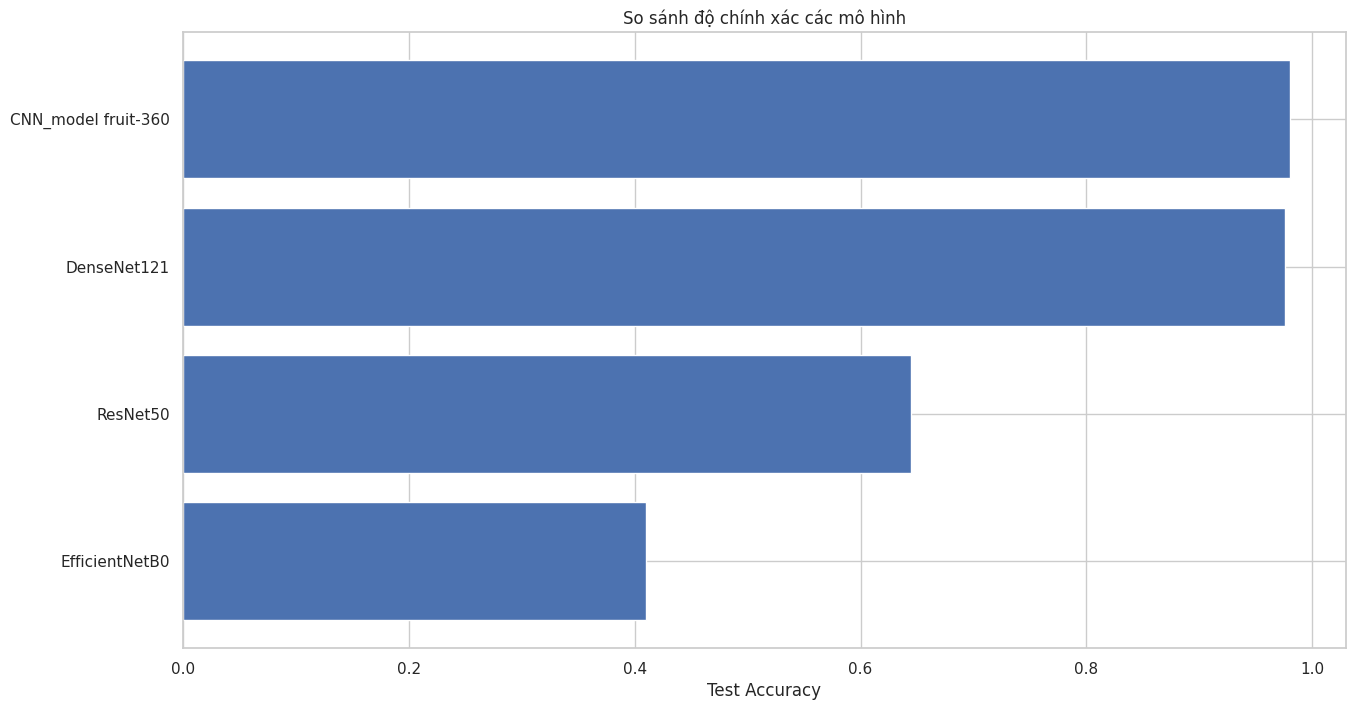

In [ ]:
df_model = pd.read_csv(os.path.join(output_dir, "summary_results (1).csv"))
df_model = df_model.sort_values("test_accuracy", ascending=False)

plt.figure(figsize=(15, 8))
plt.barh(df_model["model_name"], df_model["test_accuracy"])
plt.xlabel("Test Accuracy")
plt.title("So sánh độ chính xác các mô hình")
plt.gca().invert_yaxis()
plt.show()

* Mô hình CNN (fruit-360) đạt kết quả cao nhất, theo sau là DenseNet121.

* ResNet50 và EfficientNetB0 cho kết quả thấp hơn rõ rệt.